# Dartmouth Academic Grading
---

We want to offer a general or specific view for the user. That is, if someone wants to take every department into consideration, we don't care about the course numbers. However, if we are considering individual departments, compare course numbers.

What the choices should be:

- *Show all departments*
    - x-axis : department
- *Individual departments*
    - x-axis : course number

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup #HTML python parsing library
import re # used for multiple delimiter splits

In [2]:
def get_table(term):
    """
    PARAMETERS
    ----------
    term : String
        Specifies the academic quarter at Dartmouth to analyze publically accesible grade
        information (i.e., ["14X", "14F", "15W", "15S", "15X", "15F", "16W", "16S", "16W",
        "16F"])
        
    RETURNS
    -------
    Pandas DataFrame:
        Contains COURSE (Courses), ENRL (Enrollment), and MEDIAN (median grade in course) for
        specified term
        
    REQUIREMENTS
    ------------
    Pandas, Requests, BeautifulSoup
    """
    # Definitions:
    GRADE_NUM = {"A":4.0, "A /A-": 3.83, "A-":3.67, "A-/B+":3.5, "B+":3.33,
            "B+/B":3.17, "B":3.0, "B /B-":2.83, "B-":2.67, "B-/C+":2.5, "C+":2.33,
            "C+/C":2.17, "C":2.0, "C /C-":1.83, "C-":1.67, "C-/D+":1.5, "D+":1.33,
            "D+/D":1.17, "D":1.0, "E":0.0}
    
    # Lambda expressions:
    rep_nl = lambda x: x.replace("\n", " ")
    numeric = lambda x: x if x not in GRADE_NUM else GRADE_NUM[x]
    
    # First set up BeautifulSoup to help parse the HTML content
    url = "http://www.dartmouth.edu/~reg/transcript/medians/" + term + ".html"
    page = requests.get(url)
    
    if not page.ok:
        print "ERROR: Please choose a valid term"
        return None
    
    s = BeautifulSoup(page.text, 'html.parser')
    
    # Extract Rows, Columns, and Values
    rows = [r for r in s.find("table").find_all("tr")]
    cols = [rep_nl(col.get_text()) for col in rows[0].find_all("td") if col.get_text()]
    values = [value.get_text() for row in rows[1:] for value in row.find_all("td")]
    stacked_values = zip(*[values[i::4] for i in range(len(cols))])
    
    # Create the DataFrame
    df = pd.DataFrame(stacked_values, columns = cols, index = np.arange(len(stacked_values)))
    
    # Clean up the DataFrame
    grades = df.drop('TERM', axis=1)
    grades.ENRL = [int(enrl) for enrl in grades['ENRL']]
    grades.MEDIAN = [numeric(grade) for grade in grades['MEDIAN']]
    
    return grades


In [3]:
def get_dept(table):
    """
    PARAMETERS
    ----------
    table: DataFrame
        Contains the 'COURSE', 'ENRL', and 'MEDIAN' info for any academic term
    
    RETURNS
    -------
    DataFrame with 'DEPT' information that align with the 'COURSE' info from the initial table
    
    """
    depts = table['COURSE'].str[:4].to_frame()
    depts.columns = ['DEPT']
    return depts


In [4]:
def get_course_nums(table):
    """
    PARAMETERS
    ----------
    table: DataFrame
        Contains the `COURSE`, `ENRL`, and `MEDIAN` information for any academic term
    
    RETURNS
    -------
    Dataframe containing course numbers aligned with their corresponding course titles from
    the initial DataFrame `df`
    
    """
    nums_dirty = table['COURSE'].str[5:].to_frame()
    nums_list = [re.split('[- .]',str(nums_dirty.iloc[i]['COURSE']))[0] 
                 for i in range(len(nums_dirty.index))]
    nums_df = pd.DataFrame(nums_list, columns=['NUM'])
    nums_df.NUM = [int(num) for num in nums_df.NUM]
    return nums_df


In [12]:
def get_full_df():
    
    def get_term_df(term):
        """
        PARAMETERS
        ----------
        term: String
            Specifies the academic term to retrieve data for
    
        RETURNS
        -------
        DataFrame containing `DEPT`, `NUM`, `ENRL`, and `MEDIAN`; that is, the DataFrame contains
        information about the department, class number, enrolled students, and median grade for
        each class during the specified `term`
        
        """
        table = get_table(term)
        depts = get_dept(table)
        course_nums = get_course_nums(table)
        df = table.drop('COURSE', axis=1)
        df = pd.concat([depts, course_nums, df], axis=1)
        return df
    
    listed_terms = ["14X", "14F", "15W", "15S", "15X", "15F", "16W", "16S", "16X", "16F"]
    full_df = get_term_df(listed_terms[0])
    
    for term in listed_terms[1:]:
        df = get_term_df(term)
        full_df = pd.concat([full_df, df])
    
    return full_df


In [13]:
def dept_fig(df, dept):
    """
    """
    
    fig, ax = plt.subplots(figsize=(10,6))
    n = xrange(len(df.loc[dept].index))
    ax.set_xlabel('Course Nums')
    ax.set_ylabel('Median Grades')
    ax.set_title('Average Median Grades for %s Dept' %dept)
    ax.xaxis.set_ticks(np.arange(len(df.loc[dept].index)))
    
    a = df.loc[dept].index.tolist()
    ax.set_xticklabels(a, rotation='vertical')
    ax.bar(n, df.loc[dept]['MEDIAN'], alpha=0.5, align='center')
    
    plt.close()
    
    return fig


In [14]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

df = get_full_df()
depts_df = df.groupby(['DEPT']).count()
depts = depts_df.index.tolist()
df = df.groupby(['DEPT', 'NUM']).agg(np.mean)

In [15]:
i = interactive(dept_fig, df=fixed(df), dept=depts)

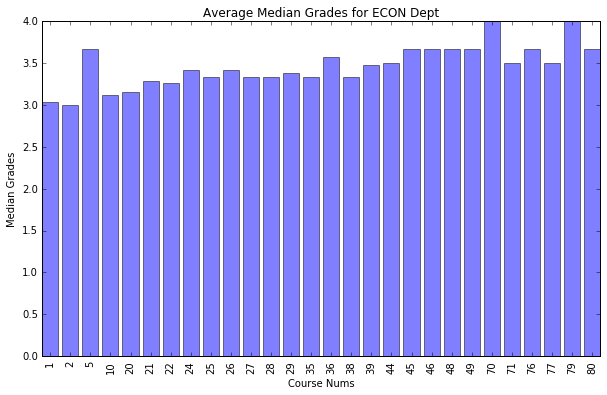

In [16]:
from IPython.display import display

display(i)